In [1]:
import pandas as pd
import numpy as np
from toolz.curried import *
import tensorflow as tf
from qrnn.data_preprocess import *
from qrnn.pipeline import pipeline
from qrnn.models import qrnn_learner
from qrnn.evaluation import *

from matplotlib import pyplot as plt
plt.style.use("ggplot")

N_LAGS=14
PRICE_COLS = ["Adjusted Close"]

Using TensorFlow backend.


In [2]:
data  = pd.read_csv('SP500.csv', usecols=['Adjusted Close', 'Date'])
data.head()

,Date,Adjusted Close
0,2016-10-13,2132.550049
1,2016-10-12,2139.179932
2,2016-10-11,2136.729980
3,2016-10-10,2163.659912
4,2016-10-07,2153.739990


In [3]:
differ_learner = diff_log_pricer(price_columns=PRICE_COLS, date_column="Date")
lagger_learner = lagger(n_lags=N_LAGS, price_columns=PRICE_COLS)
na_clearn_learner = clean_nan(how="any")

In [4]:
pipe_learner = pipeline(learners=[differ_learner, lagger_learner, na_clearn_learner])
processed_data = pipe_learner(data)

In [5]:
splitter = time_split_dataset(train_start_date="1960-01-01", train_end_date="2010-01-01", holdout_end_date="2016-01-01", date_col="Date")
train, test = splitter(processed_data)
train.head()

,Adjusted Close,Adjusted Close1,Adjusted Close10,Adjusted Close11,Adjusted Close12,Adjusted Close13,Adjusted Close14,Adjusted Close2,Adjusted Close3,Adjusted Close4,Adjusted Close5,Adjusted Close6,Adjusted Close7,Adjusted Close8,Adjusted Close9,Date
2511,0.033391,0.798008,-0.842874,-1.076771,-0.349834,0.245011,0.296714,-0.431461,-0.734442,-0.318817,-1.234479,-0.614441,-0.566570,0.549452,-0.034254,1960-01-04
2512,0.798008,-0.431461,-1.076771,-0.349834,0.245011,0.296714,-1.051169,-0.734442,-0.318817,-1.234479,-0.614441,-0.566570,0.549452,-0.034254,-0.842874,1960-01-05
2513,-0.431461,-0.734442,-0.349834,0.245011,0.296714,-1.051169,0.140799,-0.318817,-1.234479,-0.614441,-0.566570,0.549452,-0.034254,-0.842874,-1.076771,1960-01-06
2514,-0.734442,-0.318817,0.245011,0.296714,-1.051169,0.140799,-0.246522,-1.234479,-0.614441,-0.566570,0.549452,-0.034254,-0.842874,-1.076771,-0.349834,1960-01-07
2515,-0.318817,-1.234479,0.296714,-1.051169,0.140799,-0.246522,-1.045645,-0.614441,-0.566570,0.549452,-0.034254,-0.842874,-1.076771,-0.349834,0.245011,1960-01-08


In [6]:
var_estimator, train_pred = qrnn_learner(train, price_cols=PRICE_COLS, target_col="Adjusted Close14", epochs=10, lr=1e-3)
test_pred = var_estimator(test)

In [7]:
quantile_eval_fn = quantile_loss_evaluator(predict_col="prediction",
                                           target_col="Adjusted Close14",
                                           tau=0.05)

hits_eval_fn = proportion_of_hits_evaluator(predict_col="prediction",
                                                target_col="Adjusted Close14")

In [8]:
print("Quantile loss on train %f and test %f sets" % tuple(map(quantile_eval_fn, [train_pred, test_pred])))
print("Number of hits on train %f and test %f sets" % tuple(map(hits_eval_fn, [train_pred, test_pred])))

Quantile loss on train 0.101865 and test 0.113899 sets
Number of hits on train 0.046480 and test 0.061589 sets


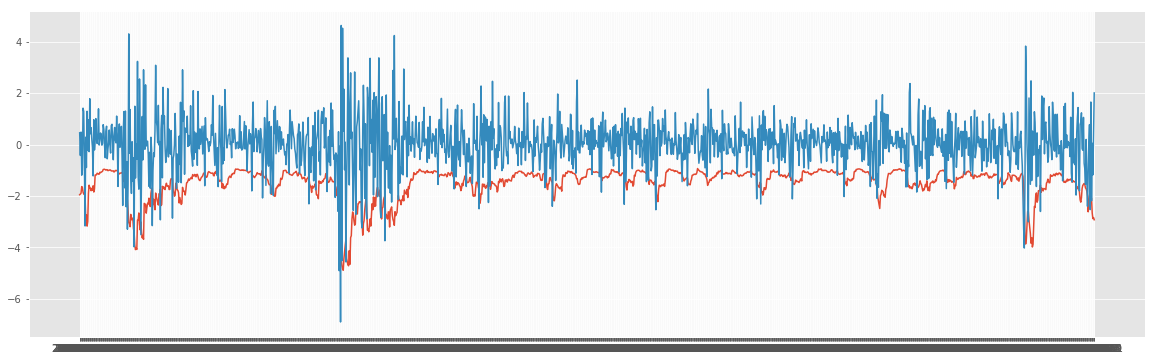

In [9]:
plt.figure(figsize=(20, 6))
plt.plot(test_pred["Date"], test_pred["prediction"])
plt.plot(test_pred["Date"], test_pred["Adjusted Close14"])